In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Załadowanie danych

Załadowanie danych z plików csv zarówno z folderów `alpha_diversity`, jak i `input_data` dla `donorA`, `donorB`, `male`, `female` z dniowym krokiem czasowym do pandas DataFrame

In [2]:
import os

alpha_diversity_dir = "data/alpha_diversity/"
input_data_dir = "data/input_data/"

def convert_to_dt_df(file):
    df = pd.read_csv(file)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df['time_step'] = pd.to_timedelta(df['time_step'], unit='D').dt.days
    df.set_index('time_step', inplace=True)
    return df

In [3]:
alpha_diversity_dfs = {}
input_data_dfs = {}

for file in os.listdir(alpha_diversity_dir):
    if file.endswith(".csv"):
        var_name = os.path.splitext(file)[0]
        file_path = os.path.join(alpha_diversity_dir, file)
        alpha_diversity_dfs[var_name] = convert_to_dt_df(file_path)

for file in os.listdir(input_data_dir):
    if file.endswith(".csv"):
        var_name = os.path.splitext(file)[0]
        base_name = var_name.split('_')[0]
        file_path = os.path.join(input_data_dir, file)
        input_data_dfs[base_name] = convert_to_dt_df(file_path)

Połączenie DataFrame w szeregi: `donorA`, `donorB`, `male`, `female`

In [4]:
alpha_diversity_combined_dfs = {}
for name, df in alpha_diversity_dfs.items():
    base_name = name.split('_')[0]

    if base_name not in alpha_diversity_combined_dfs:
        alpha_diversity_combined_dfs[base_name] = df.copy()
    else:
        alpha_diversity_combined_dfs[base_name] = alpha_diversity_combined_dfs[base_name].join(df, how='outer')

## Wizualizacja
Wizualizacja danych szeregów dla obu zbiorów: 
- `alpha_diversity`: parametry `faith_pd` oraz `shannon_entropy` 
- `input_data`: wszystkie szeregi w mikrobiomie oraz sumaryczna liczba mikrobiomu

dla każdego z szeregów: `donorA`, `donorB`, `male`, `female`.

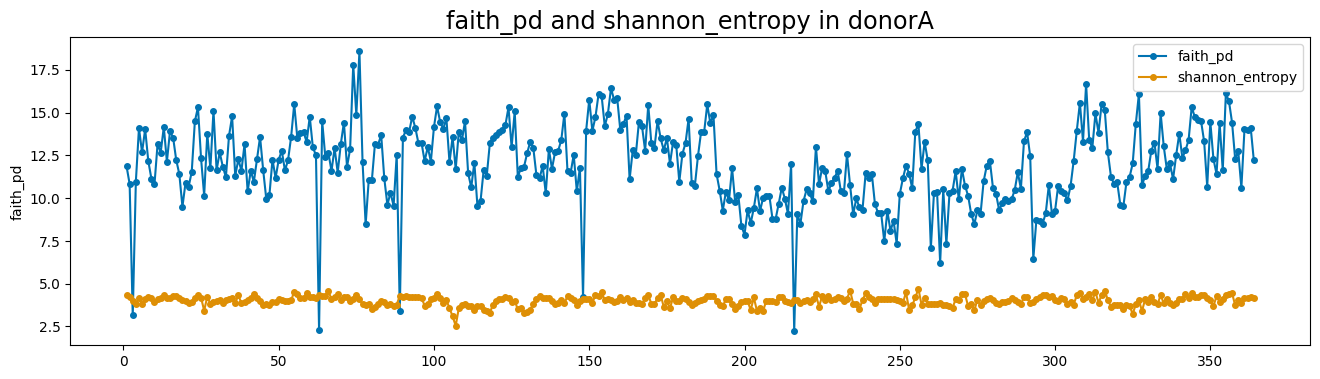

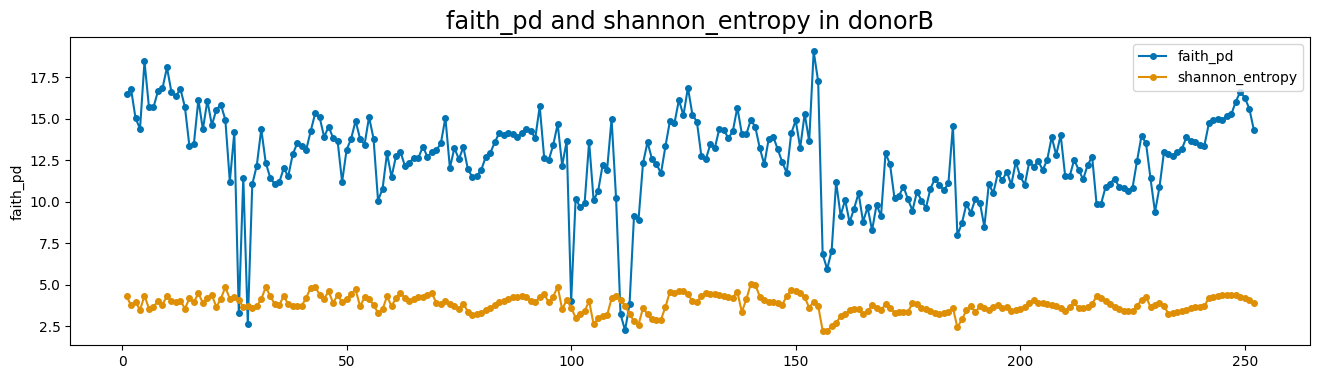

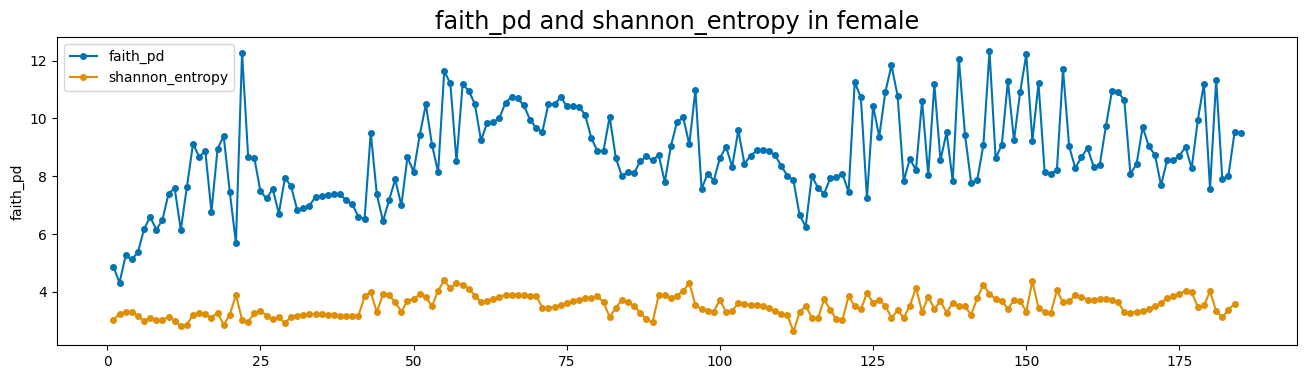

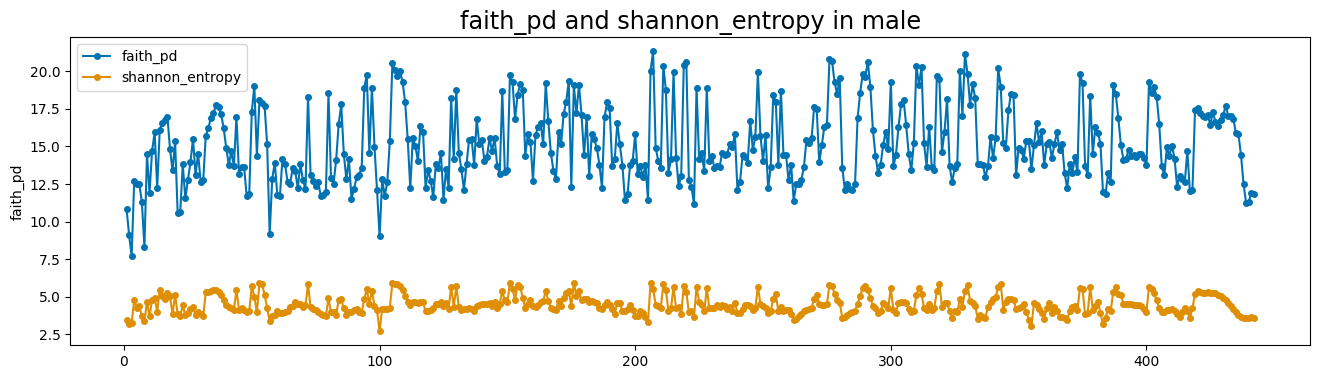

In [5]:
from sktime.utils.plotting import plot_series

# for name, df in alpha_diversity_dfs.items():
#     plot_series(df, title=f"{name}")

for name, df in alpha_diversity_combined_dfs.items():
    plot_series(df["faith_pd"], df["shannon_entropy"], labels=["faith_pd", "shannon_entropy"], title=f"faith_pd and shannon_entropy in {name}")

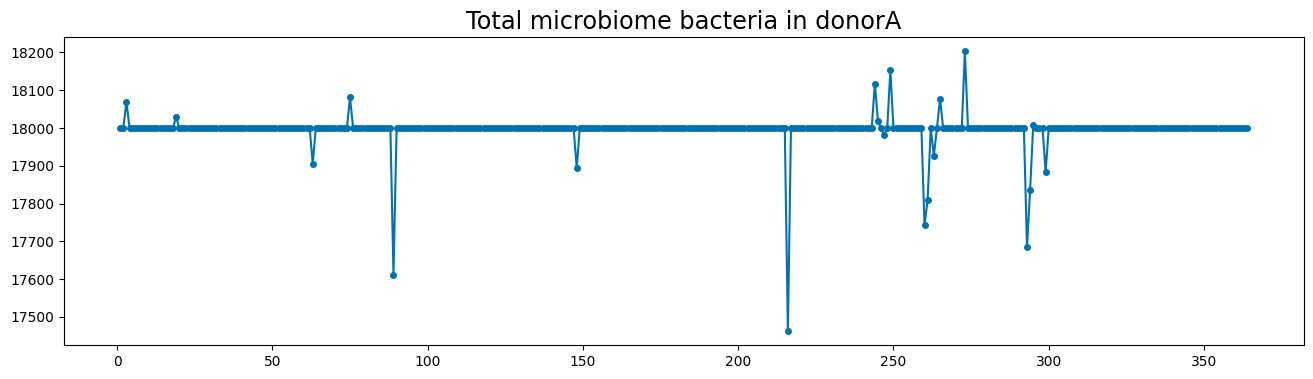

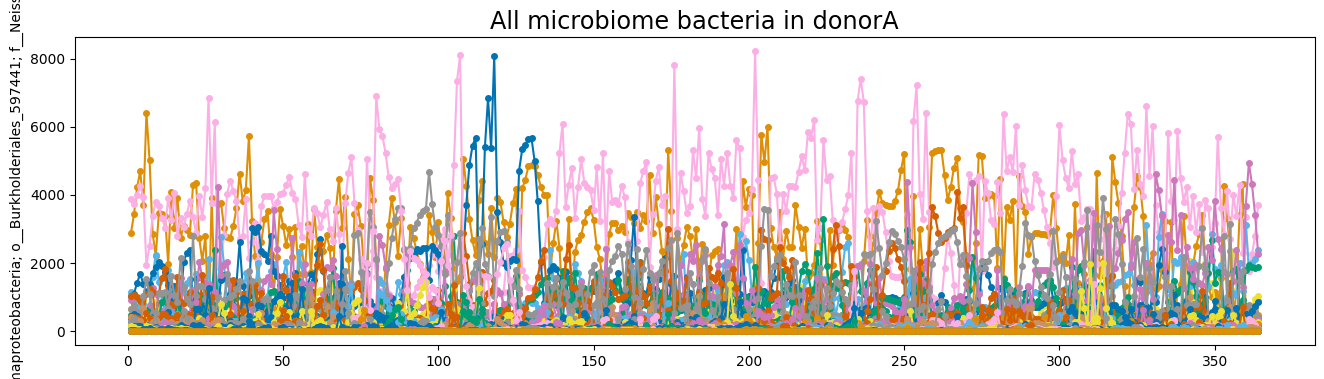

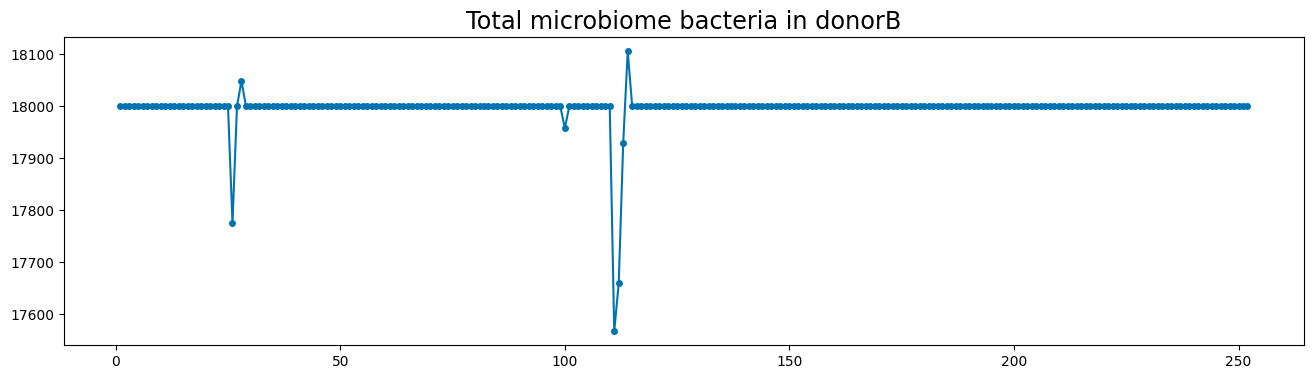

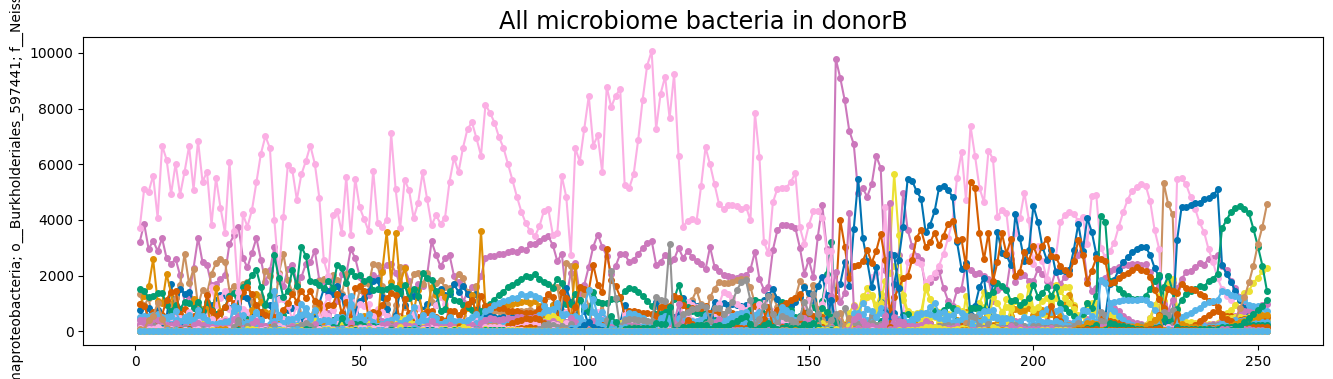

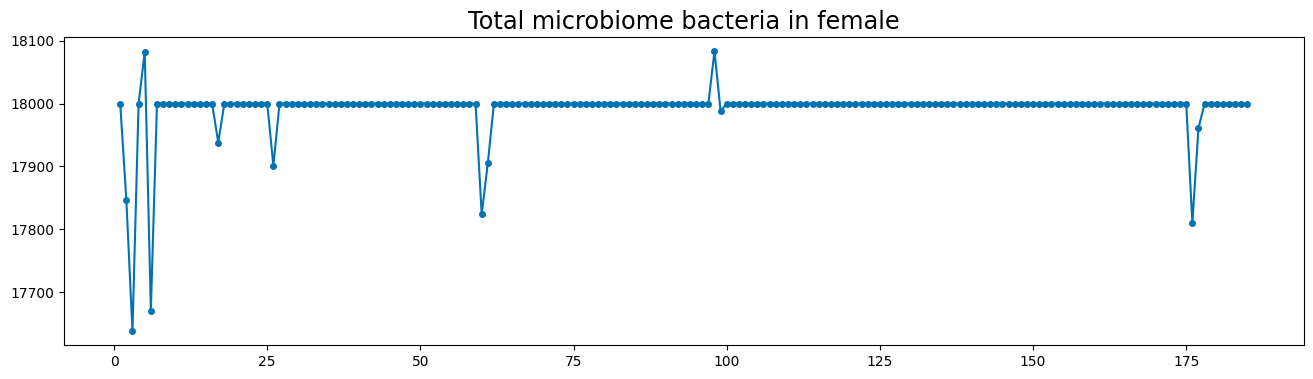

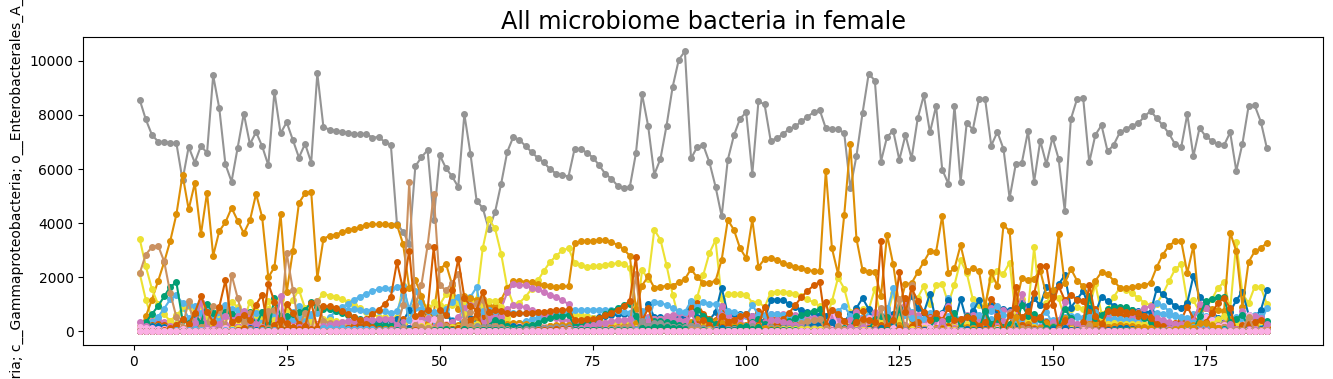

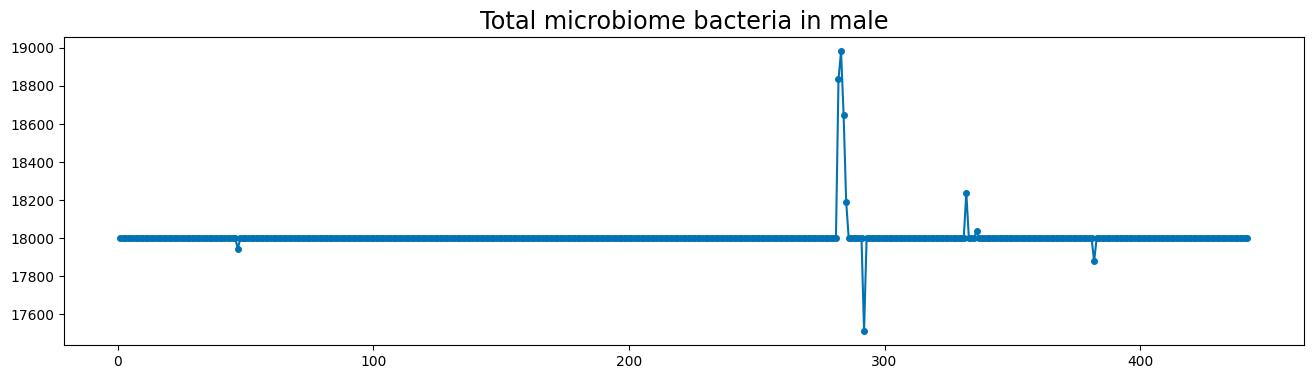

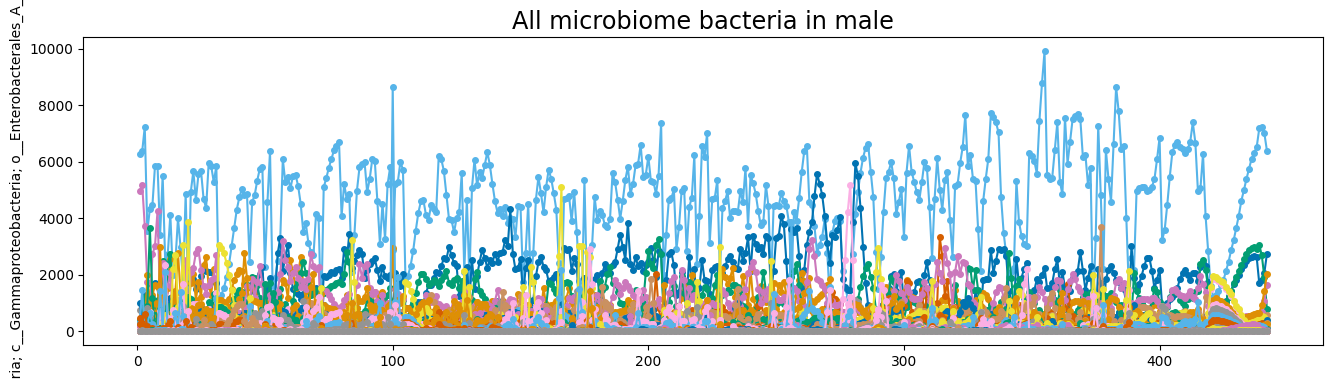

In [6]:
for name, df in input_data_dfs.items():
    plot_series(df.sum(axis="columns"), title=f"Total microbiome bacteria in {name}")

    plot_series(*[df[col] for col in df.columns], labels=None, title=f"All microbiome bacteria in {name}")

## Preprocessing

Podział zbioru danych na treningowy-testowy z forecastem wynoscącym 20% zbioru oraz zbiorem treningowym wynoszącym 80%. Przygotowanie danych (df) w odpowiednim dla frameworku neuralforecast formacie long.

In [7]:
from typing import Optional


def wide_to_long_df(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.melt(df, ignore_index=False).reset_index(names="date")
    df = df.rename(columns={"variable": "unique_id", "date": "ds", "value": "y"})
    return df


def long_to_wide_df(df: pd.DataFrame, values_col: Optional[str] = None) -> pd.DataFrame:
    if "unique_id" not in df.columns:
        df = df.reset_index(names="unique_id")

    values_col = values_col if values_col else df.columns[-1]
    df = pd.pivot(df, columns="unique_id", index="ds", values=values_col)
    return df

In [8]:
def train_test_split(df):
    cutoff = df.index[round(len(df) * 0.8)]
    train = df.loc[df.index < cutoff]
    test = df.loc[df.index >= cutoff]
    return train, test

datasets_long = []

alpha_diversity_train = {}
alpha_diversity_test = {}
alpha_diversity_train_long = {}
alpha_diversity_test_long = {}
for key, df in alpha_diversity_combined_dfs.items():
    alpha_diversity_train[key], alpha_diversity_test[key] = train_test_split(df)
    alpha_diversity_train_long[key] = wide_to_long_df(alpha_diversity_train[key])
    alpha_diversity_test_long[key] = wide_to_long_df(alpha_diversity_test[key])
    datasets_long.append((f"alpha_diversity_{key}", alpha_diversity_train_long[key], alpha_diversity_test_long[key]))

input_data_train = {}
input_data_test = {}
input_data_train_long = {}
input_data_test_long = {}
for key, df in input_data_dfs.items():
    input_data_train[key], input_data_test[key] = train_test_split(df)
    input_data_train_long[key] = wide_to_long_df(input_data_train[key])
    input_data_test_long[key] = wide_to_long_df(input_data_test[key])
    datasets_long.append((f"input_data_{key}", input_data_train_long[key], input_data_test_long[key]))

In [9]:
datasets_long

[('alpha_diversity_donorA',
        ds        unique_id          y
  0      1         faith_pd  11.871713
  1      2         faith_pd  10.830663
  2      3         faith_pd   3.143876
  3      4         faith_pd  10.965869
  4      5         faith_pd  14.088674
  ..   ...              ...        ...
  577  287  shannon_entropy   4.046674
  578  288  shannon_entropy   3.905217
  579  289  shannon_entropy   3.830544
  580  290  shannon_entropy   4.200937
  581  291  shannon_entropy   4.202723
  
  [582 rows x 3 columns],
        ds        unique_id          y
  0    292         faith_pd  12.441495
  1    293         faith_pd   6.455885
  2    294         faith_pd   8.752453
  3    295         faith_pd   8.658799
  4    296         faith_pd   8.510678
  ..   ...              ...        ...
  141  360  shannon_entropy   3.844798
  142  361  shannon_entropy   4.136168
  143  362  shannon_entropy   4.176964
  144  363  shannon_entropy   4.213700
  145  364  shannon_entropy   4.140885
  
  [1

## Trening, ewaluacja

Przygotowanie funkcji treningowej, która przyjmuje model, dane treningowe, testowe i zwraca predykcje. Funkcja treningowa przekazywana jest jako argument funkcji służącej do ewaluacji modelu, gdzie dla każdego szeregu: `donorA`, `donorB`, `male`, `female` mierzone są MAE (Mean Absolute Error) oraz MASE (Mean Absolute Scaled Error) na zbiorze testowym.

In [10]:
# !pip install neuralforecast

In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TCN, TimesNet, TFT
from neuralforecast.auto import AutoTCN, AutoTimesNet, AutoTFT
from neuralforecast.losses.pytorch import MAE
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [84]:
import numpy as np
import pandas as pd
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from neuralforecast import NeuralForecast

def forecast_general(df_train_long, df_test_long, model, freq=1):
    nf = NeuralForecast(models=[model], freq=freq)
    nf.fit(df=df_train_long)
    forecast_df = nf.predict().reset_index()
    y_pred = forecast_df[forecast_df['ds'].isin(df_test_long['ds'])]
    y_pred = y_pred.set_index(['unique_id', 'ds'])
    return y_pred

def calculate_mase_for_forecast(y_true, y_pred, y_train):
    return mean_absolute_scaled_error(y_true, y_pred, y_train=y_train)

def evaluate_forecasters(forecasters, datasets, forecast_func):
    results_dict = {}
    for dataset_name, forecaster_name, forecaster_type, forecaster in forecasters:
        for ds_name, df_train_long, df_test_long in datasets:
            if ds_name != dataset_name:
                continue

            y_pred = forecast_func(df_train_long, df_test_long, forecaster)
            y_true = df_test_long.set_index(['unique_id', 'ds'])['y']

            common_idx = y_pred.index.intersection(y_true.index)
            y_pred = y_pred.loc[common_idx].dropna()
            y_true = y_true.loc[common_idx].dropna()
            final_idx = y_pred.index.intersection(y_true.index)
            y_pred = y_pred.loc[final_idx]
            y_true = y_true.loc[final_idx]

            if len(y_true) == 0 or len(y_pred) == 0:
                mase = np.nan
            else:
                mase = mean_absolute_scaled_error(
                    y_true=y_true,
                    y_pred=y_pred.iloc[:, 0],
                    y_train=df_train_long['y'].dropna()
                )

            if forecaster_name not in results_dict:
                results_dict[forecaster_name] = {
                    "Forecaster": forecaster_name,
                    "Forecaster type": forecaster_type
                }
            results_dict[forecaster_name][f"MASE ({ds_name})"] = mase

    return pd.DataFrame.from_dict(results_dict, orient='index').reset_index(drop=True)


### Trening, ewaluacja modeli TFT, TCN,  TimesNet

Trening modeli: **TFT** (Temporal Fusion Transformer), **TCN** (Temporal Convolutional Network),  **TimesNet** z `forecast_horizon=30` oraz funkcją kosztu **MAE** (Mean Absolute Error). Reszta hiperparametrów modeli dobrana empirycznie.


In [13]:
tft_params = {
    'h': 30,
    'input_size': 14,
    'hidden_size': 64,
    'n_head': 4,
    'dropout': 0.1,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 64,
    'val_check_steps': 50,
    'loss': MAE(),
}

tcn_params = {
    'h': 30,
    'input_size': 30,
    'kernel_size': 3,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}

timesnet_params = {
    'h': 30,
    'input_size': 96,
    'hidden_size': 64,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}


In [14]:
models = []
for ds_name, _, _ in datasets_long:
    tft_model = TFT(**tft_params)
    models.append((ds_name, "TFT", "Transformer", tft_model))
    
    tcn_model = TCN(**tcn_params)
    models.append((ds_name, "TCN", "Convolutional", tcn_model))

    timesnet_model = TimesNet(**timesnet_params)
    models.append((ds_name, "TimesNet", "Convolutional", timesnet_model))

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [15]:
results_df = evaluate_forecasters(models, datasets_long, forecast_general)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | MAE                      | 0      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 256    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 154 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 64.8 K | train
6 | output_adapter          | Linear                   | 65     | train
-----------------------------------------------------------------------------
220 K     Trainable params
0         Non-trainable params
220 K     Total params
0.880     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                       | Params | Mode 
-----------------------------------------------------------------------
0 | loss            | MAE                        | 0      | train
1 | padder          | ConstantPad1d              | 0      | train
2 | scaler          | TemporalNorm               | 0      | train
3 | hist_encoder    | TemporalConvolutionEncoder | 481 K  | train
4 | context_adapter | Linear                     | 60.3 K | train
5 | mlp_decoder     | MLP                        | 2.4 K  | train
-----------------------------------------------------------------------
544 K     Trainable params
0         Non-trainable params
544 K     Total params
2.177     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | loss           | MAE           | 0      | train
1 | padder_train   | ConstantPad1d | 0      | train
2 | scaler         | TemporalNorm  | 0      | train
3 | model          | ModuleList    | 4.7 M  | train
4 | enc_embedding  | DataEmbedding | 192    | train
5 | layer_norm     | LayerNorm     | 128    | train
6 | predict_linear | Linear        | 12.2 K | train
7 | projection     | Linear        | 65     | train
---------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.800    Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [16]:
results_df

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.134505,2.070935,1.202105,1.140523
2,TimesNet,Convolutional,1.490196,0.921767,1.231429,1.092676,1.113653,1.513390,1.120646,1.213380


### Trening, ewaluacja modeli rekurencyjnych RNN, LSTM

Trening modeli: **RNN** (Recurrent Neural Network), **LSTM** (Long Short-Term Memory) z `forecast_horizon=30` oraz funkcją kosztu **MAE** (Mean Absolute Error). Reszta hiperparametrów modeli dobrana empirycznie.

In [54]:
from neuralforecast.models import RNN, LSTM

rnn_params = {
    'h': 30,
    'input_size': 60,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}

lstm_params = {
    'h': 30,
    'input_size': 60,
    'learning_rate': 1e-3,
    'max_steps': 300,
    'batch_size': 32,
    'val_check_steps': 50,
    'loss': MAE(),
}

In [55]:
recurrent_models = []
for ds_name, _, _ in datasets_long:
    rnn_model = RNN(**rnn_params)
    recurrent_models.append((ds_name, "RNN", "Recurrent", rnn_model))

    lstm_model = LSTM(**lstm_params)
    recurrent_models.append((ds_name, "LSTM", "Recurrent", lstm_model))

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


In [56]:
results_recurrent_df = evaluate_forecasters(recurrent_models, datasets_long, forecast_general)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | RNN           | 121 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
183 K     Trainable params
0         Non-trainable params
183 K     Total params
0.735     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | loss            | MAE           | 0      | train
1 | padder          | ConstantPad1d | 0      | train
2 | scaler          | TemporalNorm  | 0      | train
3 | hist_encoder    | LSTM          | 484 K  | train
4 | context_adapter | Linear        | 60.3 K | train
5 | mlp_decoder     | MLP           | 2.4 K  | train
----------------------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [57]:
results_recurrent_df

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,RNN,Recurrent,1.452844,0.700764,1.063486,1.024115,1.136139,1.761242,1.173703,1.111239
1,LSTM,Recurrent,1.253489,0.763220,1.023611,0.809704,1.127478,1.904902,1.170512,1.127681


### Trening, ewaluacja modeli ARIMA, ETS

Trening modeli: **ARIMA** (Auto Regressive Integrated Moving Average), **ETS** (ExponentialSmoothingModel).

In [71]:
from statsforecast import StatsForecast
from statsforecast.models import ARIMA, ETS

def forecast_statsforecast(df_train_long, df_test_long, stats_model, freq=1):
    h = df_test_long['ds'].nunique()
    sf = StatsForecast(models=[stats_model], freq=freq)
    sf.fit(df=df_train_long)
    forecast_df = sf.predict(h=h).reset_index()
    model_col = stats_model.__class__.__name__
    forecast_df = forecast_df.rename(columns={model_col: 'y_pred'})

    merged_df = pd.merge(
        forecast_df[['unique_id', 'ds', 'y_pred']],
        df_test_long[['unique_id', 'ds']],
        on=['unique_id', 'ds'],
        how='inner'
    )

    return merged_df.set_index(['unique_id', 'ds'])[['y_pred']]



In [88]:
statistical_models = []
for ds_name, _, _ in datasets_long:
    arima_model = ARIMA()
    statistical_models.append((ds_name, "ARIMA", "Statistical", arima_model))
    
    ets_model = ETS()
    statistical_models.append((ds_name, "ETS", "Statistical", ets_model))

In [89]:
results_statistical_df = evaluate_forecasters(statistical_models, datasets_long, forecast_statsforecast)

In [90]:
results_statistical_df

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,ARIMA,Statistical,1.120042,0.936906,1.029656,0.925325,1.420105,2.510926,1.352210,1.494939
1,ETS,Statistical,1.092582,1.026449,1.137352,0.961094,1.830633,2.072330,1.289538,1.581058


## Wyniki

Wypisanie zagregowanych wyników, wykresy dla poszczególnych modeli dla obu zbiorów (`alpha_diversity`, `input_data`) osobno oraz razem. 

In [92]:
final_results_df = pd.concat([results_df, results_recurrent_df, results_statistical_df], axis=0)
final_results_df.reset_index(drop=True, inplace=True)
final_results_df

,Forecaster,Forecaster type,MASE (alpha_diversity_donorA),MASE (alpha_diversity_donorB),MASE (alpha_diversity_female),MASE (alpha_diversity_male),MASE (input_data_donorA),MASE (input_data_donorB),MASE (input_data_female),MASE (input_data_male)
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.134505,2.070935,1.202105,1.140523
2,TimesNet,Convolutional,1.490196,0.921767,1.231429,1.092676,1.113653,1.513390,1.120646,1.213380
3,RNN,Recurrent,1.452844,0.700764,1.063486,1.024115,1.136139,1.761242,1.173703,1.111239
4,LSTM,Recurrent,1.253489,0.763220,1.023611,0.809704,1.127478,1.904902,1.170512,1.127681
5,ARIMA,Statistical,1.120042,0.936906,1.029656,0.925325,1.420105,2.510926,1.352210,1.494939
6,ETS,Statistical,1.092582,1.026449,1.137352,0.961094,1.830633,2.072330,1.289538,1.581058


In [10]:
def plot_results(df, donor_groups, weights):
    forecasters = df['Forecaster']

    plt.figure(figsize=(12, 8))
    x = np.arange(len(forecasters))

    bar_width = 0.1
    offsets = np.linspace(-bar_width * len(donor_groups) / 2, bar_width * len(donor_groups) / 2, len(donor_groups))

    colors = plt.cm.tab10(np.linspace(0, 1, len(donor_groups)))

    for i, group in enumerate(donor_groups):
        plt.bar(x + offsets[i], df[group], bar_width, label=group, color=colors[i], alpha=0.7)
        plt.plot(x + offsets[i], df[group], marker='o', color=colors[i], linestyle='-', alpha=0.9)

    normalized_weights = np.array(weights) / sum(weights)
    weighted_mean_mase = (df[donor_groups] * normalized_weights).sum(axis=1)

    plt.plot(x, weighted_mean_mase, marker='D', color='blue', linestyle='--', label='Weighted Mean MASE', markersize=8, alpha=0.8)

    for i, mean in enumerate(weighted_mean_mase):
        plt.text(x[i], mean + 0.02, f'{mean:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

    plt.xticks(x, forecasters, rotation=45, ha='right')
    plt.xlabel("Forecasters")
    plt.ylabel("MASE Values")
    plt.title("MASE Comparison Across Donor Groups and Models")
    plt.legend(title="Donor Groups", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    plt.show()

def get_weighted_mean_per_forecaster(df, donor_groups, weights):
    """Calculate weighted mean MASE for specified donor groups."""
    normalized_weights = np.array(weights) / sum(weights)
    weighted_mean = (df[donor_groups] * normalized_weights).sum(axis=1)
    df['Weighted_Mean_MASE'] = weighted_mean
    return df

def get_weights(df, donor_groups):
    weights = 1 / df[donor_groups].mean(axis=0)
    weights = weights / weights.sum()
    return weights


### alpha_diversity

In [12]:
donor_groups_alpha_diversity = [
    "MASE(alpha_diversity_donorA)", "MASE(alpha_diversity_donorB)",
    "MASE(alpha_diversity_female)", "MASE(alpha_diversity_male)",
]

weights_alpha_diversity = get_weights(final_results_df, donor_groups_alpha_diversity)

mean_values_alpha_diversity = get_weighted_mean_per_forecaster(final_results_df, donor_groups_alpha_diversity, weights_alpha_diversity)
mean_values_alpha_diversity.sort_values(by="Weighted_Mean_MASE", ascending=True)

,Forecaster,Forecaster_type,MASE(alpha_diversity_donorA),MASE(alpha_diversity_donorB),MASE(alpha_diversity_female),MASE(alpha_diversity_male),MASE(input_data_donorA),MASE(input_data_donorB),MASE(input_data_female),MASE(input_data_male),Weighted_Mean_MASE
4,LSTM,Recurrent,1.253489,0.763220,1.023611,0.809704,1.127478,1.904902,1.170512,1.127681,0.928425
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.134505,2.070935,1.202105,1.140523,0.971335
5,ARIMA,Statistical,1.120042,0.936906,1.029656,0.925325,1.420105,2.510926,1.352210,1.494939,0.989702
3,RNN,Recurrent,1.452844,0.700764,1.063486,1.024115,1.136139,1.761242,1.173703,1.111239,1.017263
6,ETS,Statistical,1.092582,1.026449,1.137352,0.961094,1.830633,2.072330,1.289538,1.581058,1.043316
2,TimesNet,Convolutional,1.490196,0.921767,1.231429,1.092676,1.113653,1.513390,1.120646,1.213380,1.147339
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807,1.535126


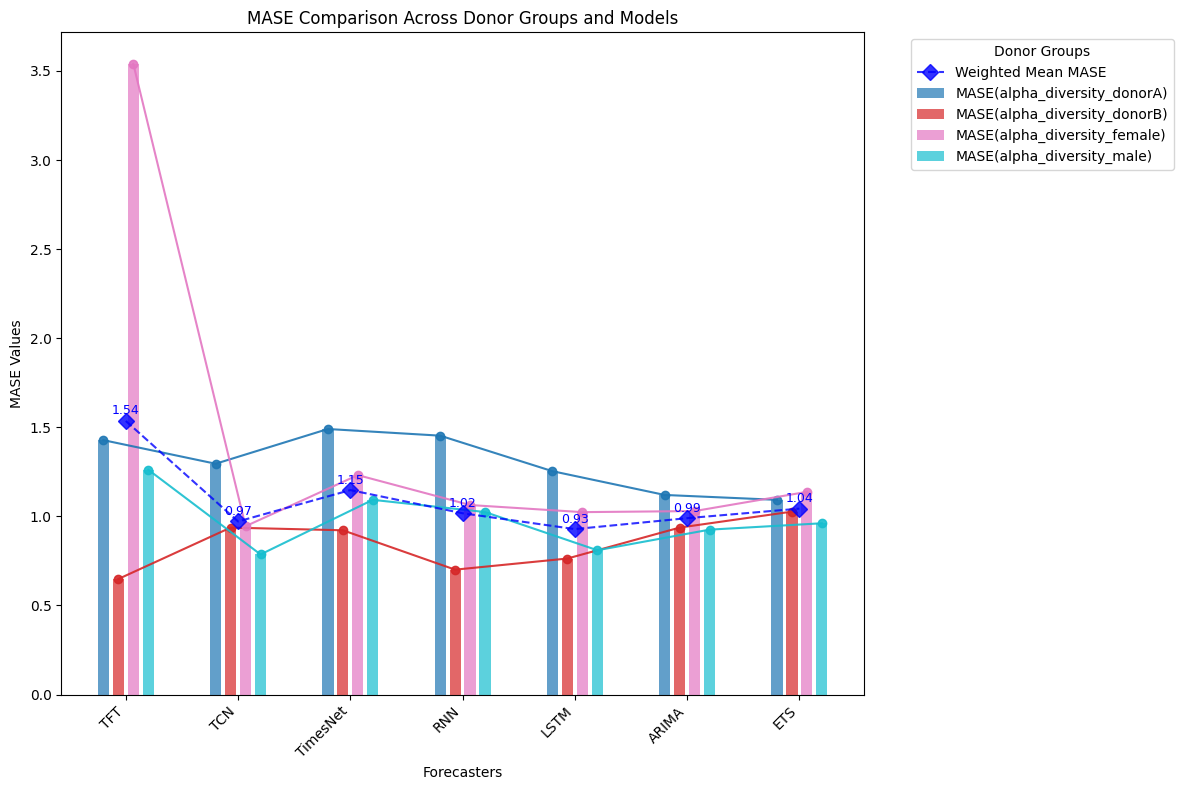

In [14]:
plot_results(final_results_df, donor_groups_alpha_diversity, weights_alpha_diversity)

### input_data

In [19]:
donor_groups_input_data = [
    "MASE(input_data_donorA)", "MASE(input_data_donorB)",
    "MASE(input_data_female)", "MASE(input_data_male)"
]

weights_input_data = get_weights(final_results_df, donor_groups_input_data)

mean_values_input_data = get_weighted_mean_per_forecaster(final_results_df, donor_groups_input_data, weights_input_data)
mean_values_input_data.sort_values(by="Weighted_Mean_MASE", ascending=True)

,Forecaster,Forecaster_type,MASE(alpha_diversity_donorA),MASE(alpha_diversity_donorB),MASE(alpha_diversity_female),MASE(alpha_diversity_male),MASE(input_data_donorA),MASE(input_data_donorB),MASE(input_data_female),MASE(input_data_male),Weighted_Mean_MASE
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807,1.151475
2,TimesNet,Convolutional,1.490196,0.921767,1.231429,1.092676,1.113653,1.513390,1.120646,1.213380,1.214316
3,RNN,Recurrent,1.452844,0.700764,1.063486,1.024115,1.136139,1.761242,1.173703,1.111239,1.252473
4,LSTM,Recurrent,1.253489,0.763220,1.023611,0.809704,1.127478,1.904902,1.170512,1.127681,1.279498
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.134505,2.070935,1.202105,1.140523,1.323656
5,ARIMA,Statistical,1.120042,0.936906,1.029656,0.925325,1.420105,2.510926,1.352210,1.494939,1.616973
6,ETS,Statistical,1.092582,1.026449,1.137352,0.961094,1.830633,2.072330,1.289538,1.581058,1.652994


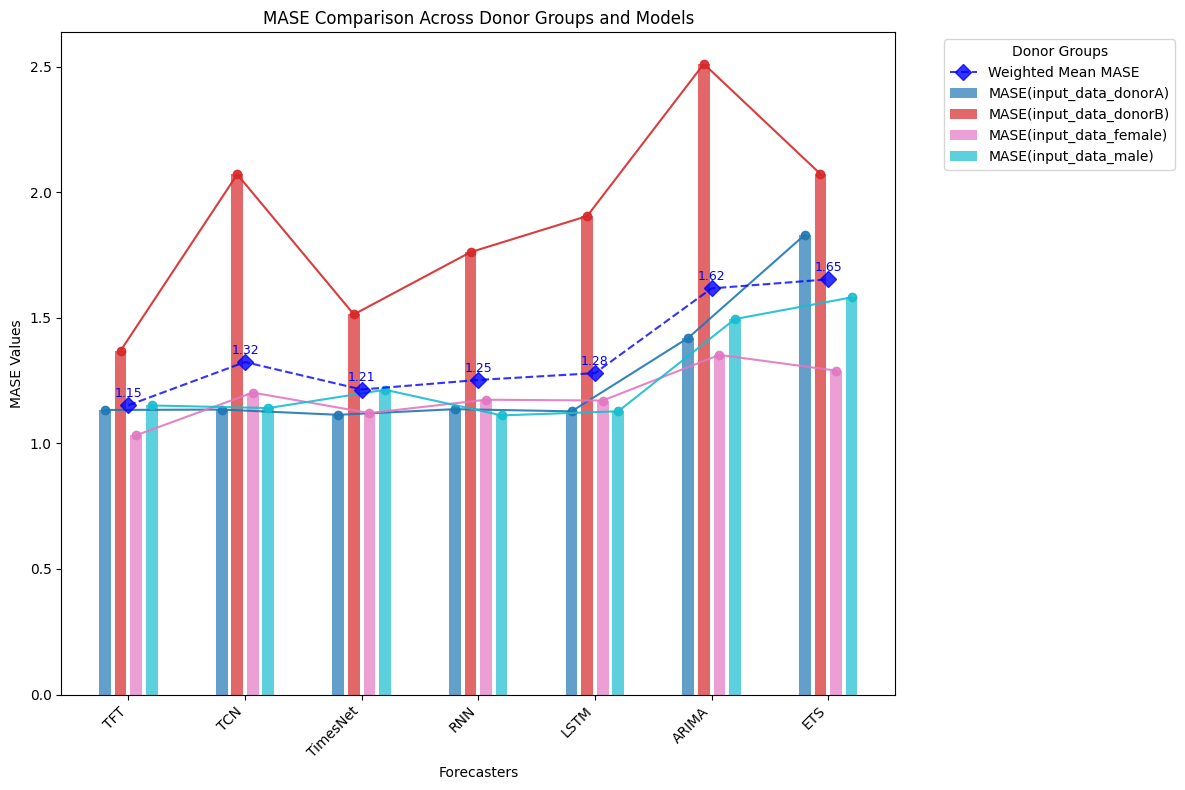

In [20]:
plot_results(final_results_df, donor_groups_input_data, weights_input_data)

## All datasets

In [21]:
donor_groups_all = [
    "MASE(alpha_diversity_donorA)", "MASE(alpha_diversity_donorB)",
    "MASE(alpha_diversity_female)", "MASE(alpha_diversity_male)",
    "MASE(input_data_donorA)", "MASE(input_data_donorB)",
    "MASE(input_data_female)", "MASE(input_data_male)"
]

weights_all = get_weights(final_results_df, donor_groups_all)

mean_values_all = get_weighted_mean_per_forecaster(final_results_df, donor_groups_all, weights_all)
mean_values_all.sort_values(by="Weighted_Mean_MASE", ascending=True)

,Forecaster,Forecaster_type,MASE(alpha_diversity_donorA),MASE(alpha_diversity_donorB),MASE(alpha_diversity_female),MASE(alpha_diversity_male),MASE(input_data_donorA),MASE(input_data_donorB),MASE(input_data_female),MASE(input_data_male),Weighted_Mean_MASE
4,LSTM,Recurrent,1.253489,0.763220,1.023611,0.809704,1.127478,1.904902,1.170512,1.127681,1.084907
3,RNN,Recurrent,1.452844,0.700764,1.063486,1.024115,1.136139,1.761242,1.173703,1.111239,1.122102
1,TCN,Convolutional,1.295229,0.936870,0.944631,0.786223,1.134505,2.070935,1.202105,1.140523,1.128372
2,TimesNet,Convolutional,1.490196,0.921767,1.231429,1.092676,1.113653,1.513390,1.120646,1.213380,1.177192
5,ARIMA,Statistical,1.120042,0.936906,1.029656,0.925325,1.420105,2.510926,1.352210,1.494939,1.269291
6,ETS,Statistical,1.092582,1.026449,1.137352,0.961094,1.830633,2.072330,1.289538,1.581058,1.315063
0,TFT,Transformer,1.427697,0.648422,3.539659,1.261534,1.132889,1.368846,1.032208,1.150807,1.364124


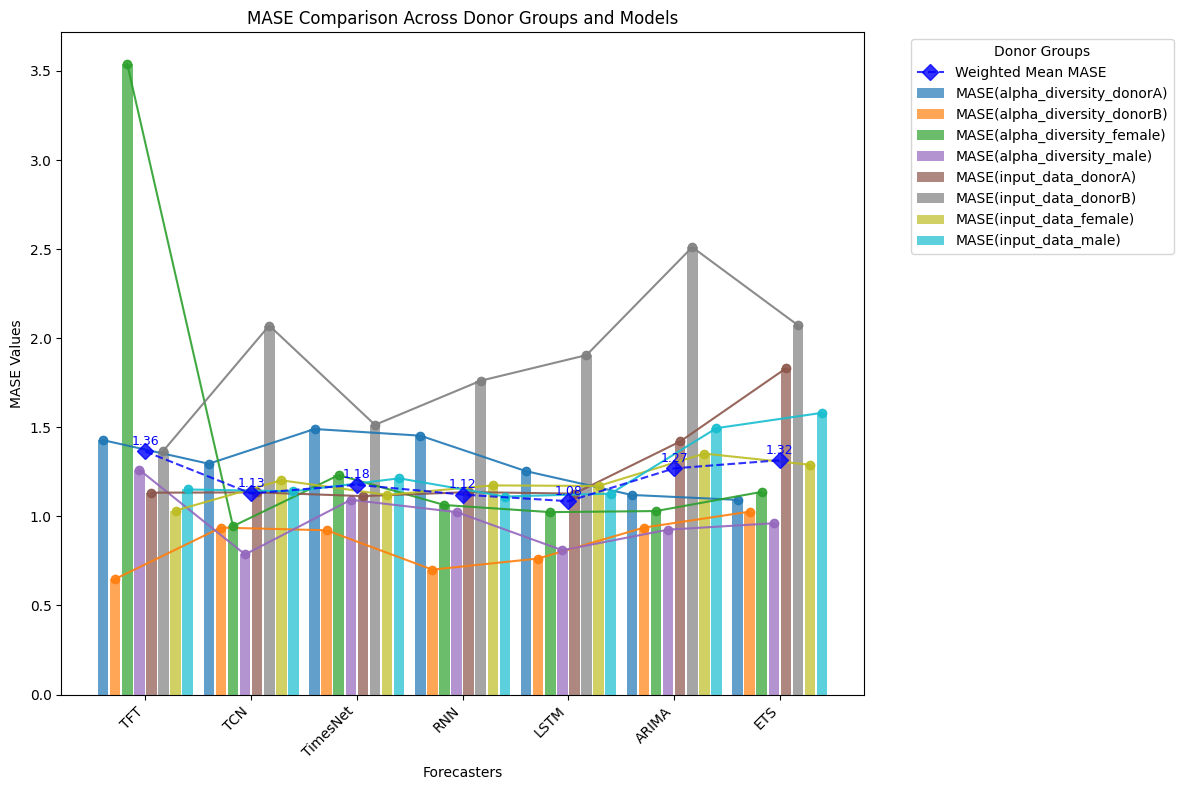

In [23]:
plot_results(final_results_df, donor_groups_all, weights_all)

## Wnioski

- **donorB** wypada najlepiej dla `alpha_diversity` w porównaniu z innymi donorami, natomiast na `input_data` najgorzej dla praktycznie każdego modelu
- **TFT** dla `alpha_diversity` **female** poradził sobie najgorzej, natomiast w przypadku `input_data` najlepiej w porównaniu z innymi modelami
- ze względu na wyraźne różnice w średnich wartościach błędów dla poszczególnych donorów zastosowaliśmy średnią ważoną z wagami uzależnionymi od poszczególnych donorów 
- najlepszym modelem w przypadku `alpha_diversity` jest **LSTM**, natomiast najgorszym **TFT**
- najlepszym modelem w przypadku `input_data` jest **TFT**, natomiast najgorszym **ETS**
- najlepszym modelem licząc oba zbiory razem jest **LSTM**, natomiast najgorszym **TFT**
- słaby wynik **TFT** jest bezpośrednio podyktowany wysokim błędem **female** na zbiorze `alpha_diversity`
